## Code to plot Figure 1 from Verboncoeur et al. (2024)

(a) plot of Ross Ice Shelf <br>
(b) plot of the Crary Ice Rise region<br>
(c) plot of data from the Smith et al. (2020) study of dh/dt<br>

Some annotations on figures made in Affinity Designer (https://affinity.serif.com/en-us/designer/)

Email hverboncoeur@mines.edu with any questions

In [1]:
import os
import h5py
import pygmt
import cmocean
import datetime
import subprocess
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as io
from glob import glob
import geopandas as gpd
from pyproj import CRS, Transformer
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
import matplotlib.pyplot as plt

quickplot = False # boolean to speed up plotting when developing

In [2]:
######
# Quick geodetic to PS71 converter from pyproj
def ll2xy(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    
    x, y = ps2ll(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y
######

######
def geographic_to_grid_bearing(lat, lon, geographic_bearing):
    # Convert latitude and longitude to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    # Convert geographic bearing to radians
    geographic_bearing_rad = np.radians(geographic_bearing)
    # Calculate the grid bearing in radians
    grid_bearing_rad = geographic_bearing_rad + lon_rad
    # Convert grid bearing back to degrees
    grid_bearing_deg = np.degrees(grid_bearing_rad)
    # Make sure the bearing is within [0, 360) range
    grid_bearing_deg = (grid_bearing_deg + 360) % 360
    return grid_bearing_deg
######

In [3]:
## We're going to data wrangle in this cell. 

# set the data paths

# I load in an environment variable that tells me where I store 
# my data. That way if I need to change the path to my data 
# folder (say, point it to an external hard drive if I am in the field) 
# I can make that switch trivially
datafold = os.getenv('HOME')

# quick error check to make sure $DATAHOME is set
if datafold is None:
    raise OSError('environment variable $DATAHOME does not exist')
    
# point to data locations

# MOA available at: 
# https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa125_2009_hp1_v02.0.tif.gz
# (doi: 10.5067/4ZL43A4619AF)
# After unzipping, I then convert it to NetCDF using GMT to reduce data volume by a factor of 4 using the line:
# > gmt grdconvert moa125_2009_hp1_v02.0.tif -Gmoa125_2009_hp1_v02.0.nc
moa = datafold + '/Documents/Research/CraryIceRise/Figure1/moa125_2009_hp1_v02.0.nc'

# old MOA shapes that are good enough for continent-scale insets (and they're small)
# grounding line: https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/coastlines/moa_2009_groundingline_v02.0.gmt
# coast line: https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/coastlines/moa_2009_coastline_v02.0.gmt
moa_coast = datafold + '/Documents/Research/CraryIceRise/Figure1/moa_2009_coastline_v02.0.gmt'
moa_gl = datafold + '/Documents/Research/CraryIceRise/Figure1/moa_2009_groundingline_v02.0.gmt'

# grounding line available at:
# https://doi.pangaea.de/10013/epic.42133.d001 (doi: 10.1594/PANGAEA.819147)
gl = datafold + '/Documents/Research/CraryIceRise/Figure1/gz/scripps_antarctica_polygons_v1.shp'

# velocity arrows/ flow direction
# data: https://nsidc.org/data/nsidc-0484/versions/2
# I created the vector field in QGIS
vel_arr = datafold + '/Documents/Research/CraryIceRise/Figure1/velarr/MEaSUREs_FlowVectors.shp'

# ice-surface velocity grid available at: 
# https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc
# (doi: 10.5067/PZ3NJ5RXRH10)
vel = datafold + '/Documents/Research/CraryIceRise/Figure1/antarctic_ice_vel_phase_map_v01.nc'

# download lake outlines from github
# https://github.com/mrsiegfried/Siegfried2021-GRL/blob/main/data/outlines/SiegfriedFricker2018-outlines.h5
lake_outlines = datafold + '/Documents/Research/CraryIceRise/Figure1/SiegfriedFricker2018-outlines.h5'

# CIR complex outline
# Created in QGIS
cir_outline=datafold + 'Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/cir_outline.shp'


In [4]:
### load subglacial lake outlines

# open lake outlines hdf5 file
h5f = h5py.File(lake_outlines, 'r')

outline_geometries = [] # store polygons
# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)
    
    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
    else:
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]
        
        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]
            pgons.append(Polygon(this_outline))
        geometry = MultiPolygon(pgons)
        
    # append all the results in the right place
    outline_geometries.append(geometry)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries), 
                  columns=['name', 'geometry'])
gdf = gpd.GeoDataFrame(df, crs=CRS("EPSG:3031"), geometry=outline_geometries)
h5f.close()


### load GZ
df_gl = gpd.read_file(gl)


## Plot RIS region (Fig. 1a)

grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline
basemap [WARNING]: For a UTM or TM projection, your region -650000/450000/-1370000/-400000 is too large to be in degrees and thus assumed to be in meters
<ipython-input-9-e35995e4dc7a>:100: SyntaxWarning: Short-form parameter (t) is not recommended. Use long-form parameter 'transparency' instead.
  fig.colorbar(cmap = 'vel.cpt', position = pos_str,
plot [WARNING]: For a UTM or TM projection, your region -650000/450000/-1370000/-400000 is too large to be in degrees and thus assumed to be in meters
plot [WARNING]: For a UTM or TM projection, your region -650000/450000/-1370000/-400000 is too large to be in degrees and thus assumed to be in meters
plot [WARNING]: For a UTM or TM projection, your region -650000/450000/-1370000/-400000 is too large to be in degrees and thus assumed to be in meters


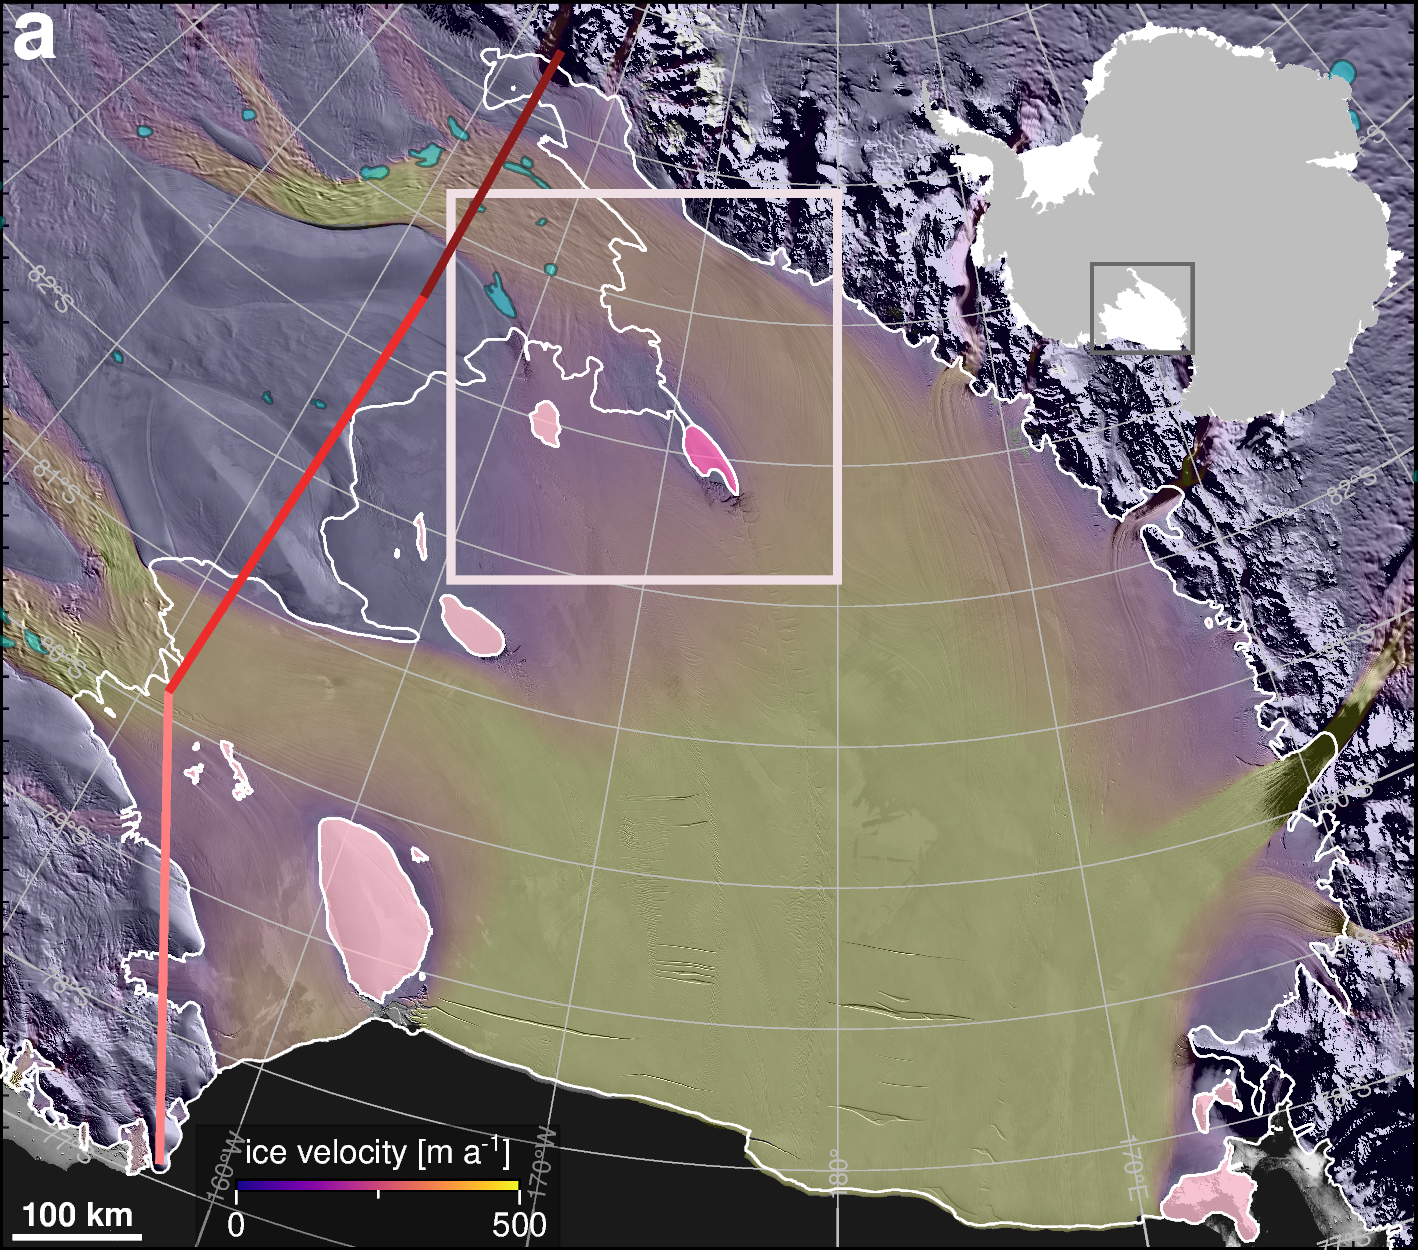

In [9]:
figwidth=120 # in mm

# Region for main part of the figure

cir_xl=-650000 #center_x[0] - wid_km*1000/4*2
cir_xh=450000 #center_x[0] + wid_km*1000/4*2
cir_yl=-1370000 #center_y[0] - hgt_km*1000/3*2 - 5000
cir_yh=-400000 #center_y[0] + hgt_km*1000/3*1 - 5000

cirratio = (cir_xh - cir_xl) / (figwidth/1000)
figheight=figwidth*(cir_yh-cir_yl)/(cir_xh-cir_xl)

cirreg = str(cir_xl) + '/' + str(cir_xh) + '/' + str(cir_yl) + '/' + str(cir_yh)
cirproj = "x1:" + str(cirratio)
cirproj_ll = "s0/-90/-71/1:" + str(cirratio)

pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', continuous = True, output = 'moa.cpt')
with pygmt.config(COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [0,500,1], cmap = 'plasma', output = 'vel.cpt')
#pygmt.makecpt(series = '-5/20/1', cmap = 'viridis', output = 'dz.cpt')
fig = pygmt.Figure()
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = cirreg, projection = cirproj, frame=["nwse", "xf25000", "yf25000"], 
                 grid = moa, cmap = 'moa.cpt')
    
if (not quickplot):
    veldata = xr.open_dataset(vel)
    vel_mag = (veldata['VX']**2 + veldata['VY']**2)**0.5
    fig.grdimage(grid = vel_mag, cmap = 'vel.cpt', transparency = 80)

    # Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '6p,grey',
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinner,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = cirproj_ll, region = cirreg,
                frame = ["SnWE", "xa10g10", "ya1g1"])
# CIR complex outline
cir_outline=datafold +'/Documents/Research/CraryIceRise/PAPER/CODE_paper/SHAPES/cir_outline.shp'
df_cir=gpd.read_file(cir_outline)
df_gl = gpd.read_file(gl)
df_gl =df_gl[(df_gl['Id_text']=='Ice rise or connected island')|(df_gl['Id_text']=='Isolated island')]
    
if not quickplot:
#     fig.plot(region = cirreg, projection = cirproj, 
#              data = drainpath['geometry'], pen = "1p,cyan", transparency = 50)
    fig.plot(region = cirreg, projection = cirproj,
             data = gdf, 
             pen = "0.5p,black", 
             color = 'cyan', 
             transparency = 60)
    
    fig.plot(region = cirreg, projection = cirproj,
             data = df_gl, 
             pen = "0.5p,white", 
             color = 'pink', 
             transparency = 20)
    fig.plot(region = cirreg, projection = cirproj,
             data = df_cir[df_cir['Id']==1], 
             pen = "0.5p,white", 
             color = 'hotpink', 
             transparency = 20)
    
# GZ        
    fig.plot(data = gl, pen = '0.5p,white')
#     fig.plot(data = vel_arr, style="v0.6c+e", pen = '0.5p', color= 'white')


# plot box around CIR region
box_xl=-300000
box_yl=-850000
box_xh=0
box_yh=-550000
fig.plot(x = [box_xl, box_xl, box_xh, box_xh, box_xl], y = [box_yl, box_yh, box_yh, box_yl, box_yl], pen = '2p,LAVENDERBLUSH2')


## Plot scale bar in lower left
wid = 100000 # scale bar width, in m
xoff = 9900 # distance from left to put scale bar, in m
yoff = 9900 # distance from bottom to put scale bar, in m
xleft = xoff
xmid = xoff + wid/2
xright = xoff + wid
fig.plot(x = [cir_xl + xleft, cir_xl + xright], y = [cir_yl + yoff, cir_yl + yoff], pen = '1.5p,white')
fig.text(x = cir_xl + xmid, y = cir_yl + yoff, text = '{:3.0f}'.format(wid/1000) + ' km', 
         font = '8p,Helvetica-Bold,white', justify = 'BC', offset = '0/0.1c')

# plot letter in upper left (20 pt helvetica)
fig.text(x = cir_xl, y = cir_yh, text = 'a', 
         font = '20p,Helvetica-Bold,white', justify = 'TL', offset = '0.1c/-0.1c')

# velocity colorbar
barwidth = figwidth/10 * 0.2 # color bar width is 20% of the map width, in cm
pos_str = 'jBL+w' + str(barwidth) + 'c+jBL+o2c/0.5c+h+ml'
# Plot the color bar once with a transparent box, then again with no box and no transparency
with pygmt.config(FONT_ANNOT_PRIMARY = '8p,white', FONT_LABEL = '8p,white', 
                  MAP_ANNOT_OFFSET_PRIMARY = '2p', MAP_TICK_PEN_PRIMARY = '0.5p,white', 
                  MAP_TICK_LENGTH_PRIMARY = '3p', MAP_FRAME_PEN = '0.5p,black', MAP_LABEL_OFFSET = '4p'):
    fig.colorbar(cmap = 'vel.cpt', position = pos_str,
                 frame = 'xa500+l"ice velocity [m a@+-1@+]"', box = '+gblack+p0.5p,black+c3p', t = '70')
    fig.colorbar(cmap = 'vel.cpt', position = pos_str, frame = 'xa500f250+l"ice velocity [m a@+-1@+]"')
    
# Make insets
antwidth = 4.5 #3.5 # width of inset in cm
antreg = '-2900000/-2900000/2900000/2900000r'
antmap = 'X' + str(antwidth) + 'c'

# generate offset string based on inset width
xoff_str = 'a' + str(figwidth/10 - antwidth) + 'c'
yoff_str = 'a' + str(figheight/9.7 - antwidth) + 'c'

fig.basemap(projection = antmap, region = antreg, frame = '+n', xshift = xoff_str, yshift = yoff_str)
fig.plot(data = moa_coast, color = 'white', xshift = xoff_str, yshift = yoff_str)
fig.plot(data = moa_gl, color = 'gray', xshift = xoff_str, yshift = yoff_str)
fig.plot(x = [cir_xl, cir_xl, cir_xh, cir_xh, cir_xl], y = [cir_yl, cir_yh, cir_yh, cir_yl, cir_yl], 
         pen = '0.9p,dimgray', xshift = xoff_str, yshift = yoff_str)

# coastline coords
cape_colbeck = [-158-1/60, -77-7/60]
shirase_south = [-155.0, -83.5]
siple_north = [-151.0, -80-10/60]
siple_south = [-153.0, -83.5]
gould_north = [-153.0, -83.5]
scott_west = [-154.0, -85.5]
morris = [-167-22/60, -84-56/60]
airdrop = [172+45/60, -83-45/60]
cape_selborn = [160+45/60, -80-23/60]
minna_bluff = [166+25/60, -78-31/60]

fig.plot(x = [cape_colbeck[0], siple_north[0]], y = [cape_colbeck[1], siple_north[1]],
         projection = cirproj_ll, region = cirreg, pen = '2p,lightred')
fig.plot(x = [siple_north[0], siple_south[0]], y = [siple_north[1], siple_south[1]], pen = '2p,firebrick2')
fig.plot(x = [gould_north[0], scott_west[0]], y = [gould_north[1], scott_west[1]], pen = '2p,firebrick4')

fig.show()

In [ ]:
out='Verboncoeur2024-fig1a.pdf'
fig.savefig(out)

# additional annotations made with Affinity Designer

## Plot CIR region (Fig. 1b)

In [10]:
figwidth=120 # in mm

# Region for main part of the figure
wid_km = 300 # region width
hgt_km = 300 # region height
cir_xl=-300000 # polar stereographic bounds
cir_xh=0 
cir_yl=-850000 
cir_yh=-550000

cirratio = (cir_xh - cir_xl) / (figwidth/1000)
figheight=figwidth*(cir_yh-cir_yl)/(cir_xh-cir_xl)

cirreg = str(cir_xl) + '/' + str(cir_xh) + '/' + str(cir_yl) + '/' + str(cir_yh)
cirproj = "x1:" + str(cirratio)
cirproj_ll = "s0/-90/-71/1:" + str(cirratio)

# gray topographic background, overlay velocity in plasma colorscale
pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', continuous = True, output = 'moa.cpt')
with pygmt.config(COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [0,500,1], cmap = 'plasma', output = 'vel.cpt')

# define the fig and plot the background
fig = pygmt.Figure()
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = cirreg, projection = cirproj, frame=["nwse", "xf25000", "yf25000"], 
                 grid = moa, cmap = 'moa.cpt')

if (not quickplot):
    veldata = xr.open_dataset(vel)
    vel_mag = (veldata['VX']**2 + veldata['VY']**2)**0.5
    fig.grdimage(grid = vel_mag, cmap = 'vel.cpt', transparency = 80)

# Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 1, FONT_ANNOT_PRIMARY = '6p,grey',
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '10p',
                  MAP_TICK_PEN_PRIMARY = 'thinner,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = cirproj_ll, region = cirreg,
                frame = ["SnWE", "xa10g10", "ya1g1"])
    

if not quickplot:
    fig.plot(region = cirreg, projection = cirproj,
             data = gdf, 
             pen = "0.5p,black", 
             color = 'cyan', 
             transparency = 60)
    fig.plot(data = gl, pen = '0.5p,white')    
    
# fig.show()

grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline
basemap [WARNING]: For a UTM or TM projection, your region -300000/0/-850000/-550000 is too large to be in degrees and thus assumed to be in meters
basemap [WARNING]: 2 annotations along the right border were skipped due to crowding.
basemap [WARNING]: 1 annotations along the left border were skipped due to crowding.
basemap [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 25.9467p.
basemap [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.


In [11]:
## Plot RIGGS velocity vectors

# RIGGS vel (data at ftp://ftp.nsidc.org/DATASETS/ANTARCT_VELOC/riggs_data.txt)
colnames=['lat', 'lon', 'v', 'deg'] 
df_R = pd.read_csv(datafold + '/Documents/Research/CraryIceRise/Figure1/RIGGS_v.csv',names=colnames, header=None)

# convert lon lat to xy
x_R,y_R=ll2xy(df_R['lon'], df_R['lat'])
df_R['x']=x_R
df_R['y']=y_R

df_R=df_R[((cir_xl<x_R) & (x_R<cir_xh))&((cir_yl<y_R) & (y_R<cir_yh))]

def cal_vel(angles, speeds):
    vel = np.empty((2, len(angles)))
    vel[0, :] = speeds*np.cos(angles)
    vel[1, :] = speeds*np.sin(angles)
    return vel

# convert angle to grid

ang=np.asarray(df_R['deg'])
lat=np.asarray(df_R['lat'])
lon=np.asarray(df_R['lon'])

grid_ang=np.nan*np.ones(len(ang))
for i in range(len(ang)):
    grid_ang[i] = geographic_to_grid_bearing(lat[i], lon[i], ang[i])
df_R['grid_ang']=grid_ang

sp=df_R['v']
ang = df_R['grid_ang']
velx,vely=cal_vel(ang,sp)

vecstyle = "v0.35c+e+h0.5"
angle = df_R['grid_ang']
length = df_R['v']/300

fig.plot(x = df_R['x'], y = df_R['y'], 
         direction = [90-angle, length], 
         style = vecstyle, pen = '1p,black',color='black')



## Plot MEaSURES vectors in same locations as RIGGS

# use pygmt grdtrack to match RIGGS/MEaSURES locations
gridvx = veldata.VX # MEaSURES locations & V's
gridvy = veldata.VY # MEaSURES locations & V's
df_MSR = df_R[['x', 'y']]
points = df_MSR # df_R need to pull out x,y pioints
newcolnamevx = 'MSR_VX'
newcolnamevy = 'MSR_VY'
# make new dataframe:
df_MSR = pygmt.grdtrack(points=points, grid=gridvx, newcolname=newcolnamevx)
df_MSR = pygmt.grdtrack(points=df_MSR, grid=gridvy, newcolname=newcolnamevy)

# plot - plotting MEaSURES vectors requires an angle (in degrees) and a length. calc from vx and vy
vecstyle = "v0.35c+e+h0.5"
angle = np.arctan2(df_MSR['MSR_VY'],df_MSR['MSR_VX'])/np.pi*180
length = np.sqrt(df_MSR['MSR_VY']**2 + df_MSR['MSR_VX']**2)/300
ix = ~np.isnan(length) # don't plot nans
fig.plot(x = df_MSR['x'].loc[ix], y = df_MSR['y'].loc[ix], 
         direction = [angle[ix], length[ix]], 
         style = vecstyle, pen = '1p,gray',color='gray')

# fig.show()

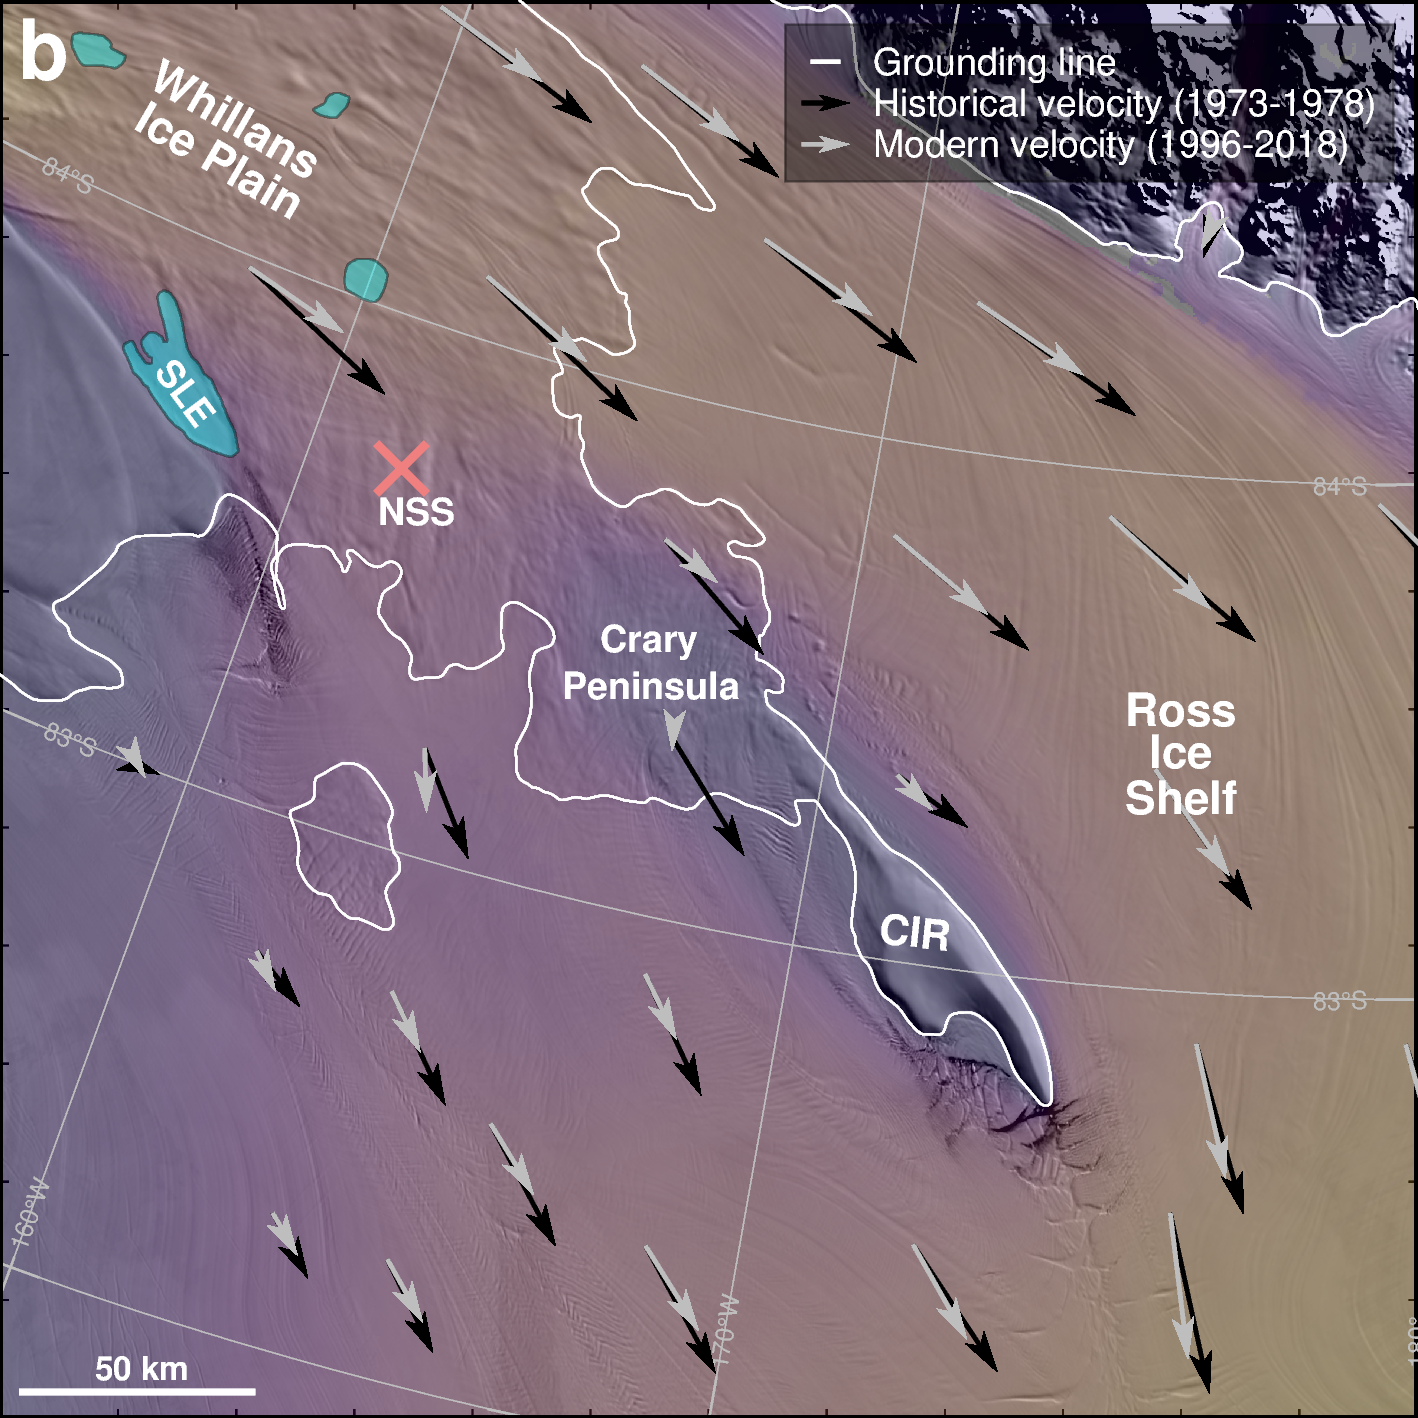

In [12]:
# include the rest of the annotations

# plot NSS
fig.plot(region = cirreg, projection = cirproj, 
         x = -215000, y = -649000, style = 'x0.6c', pen='2p,lightcoral')

## Plot scale bar in lower left
wid = 50000 # scale bar width, in m
xoff = 4050 # distance from left to put scale bar, in m
yoff = 5500 # distance from bottom to put scale bar, in m
xleft = xoff
xmid = xoff + wid/2
xright = xoff + wid
fig.plot(x = [cir_xl + xleft, cir_xl + xright], y = [cir_yl + yoff, cir_yl + yoff], pen = '1.5p,white')
fig.text(x = cir_xl + xmid, y = cir_yl + yoff, text = '{:3.0f}'.format(wid/1000) + ' km', 
         font = '8p,Helvetica-Bold,white', justify = 'BC', offset = '0/0.1c')

# plot letter in upper left (9 pt helvetica)
fig.text(x = cir_xl, y = cir_yh, text = 'b', font = '20p,Helvetica-Bold,white', justify = 'TL', offset = '0.15c/-0.15c')

# label RIS, CIR, NSS, Crary Peninsula, SLE, WIP
!echo -50000 -700000 MC Ross > tmptxt
!echo -50000 -709000 MC Ice >> tmptxt
!echo -50000 -718500 MC Shelf >> tmptxt
fig.text(textfiles = 'tmptxt', font = '11p,Helvetica-Bold,white', justify = True)
os.remove('tmptxt')
!echo -113500 -743000 TL CIR >> tmptxt
fig.text(textfiles = 'tmptxt', font = '10p,Helvetica-Bold,white', justify = True,angle = -6)
os.remove('tmptxt')
!echo -220000 -655000 TL NSS >> tmptxt
!echo -173000 -682000 TL Crary >> tmptxt
!echo -181000 -692000 TL Peninsula >> tmptxt
fig.text(textfiles = 'tmptxt', font = '9p,Helvetica-Bold,white', justify = True)
os.remove('tmptxt')
!echo -263000 -625000 TL SLE >> tmptxt
fig.text(textfiles = 'tmptxt', font = '9p,Helvetica-Bold,white', justify = True,angle = -53)
os.remove('tmptxt')
!echo -250000 -575000 MC Whillans > tmptxt
!echo -253400 -583800 MC Ice Plain >> tmptxt
fig.text(textfiles = 'tmptxt', font = '11p,Helvetica-Bold,white', justify = True, angle = -30)
os.remove('tmptxt')

#######
## Plot legend with symbols; plot scale bars below the figure
# make legend file and plot it

!echo 'S - - 0.25c - 1p,white - Grounding line' >> legend.txt
!echo 'S - v0.25c+e 0.4c black 1.1p,black - Historical velocity (1973-1978)' >> legend.txt
!echo 'S - v0.25c+e 0.4c gray 1.1p,gray - Modern velocity (1996-2018)' >> legend.txt

with pygmt.config(FONT_ANNOT_PRIMARY = '9p,white', FONT_LABEL='9p,Helvetica', 
                  MAP_FRAME_PEN = '0.5p'):
    fig.legend(region = cirreg, projection = cirproj, 
               spec = 'legend.txt', position = 'JTR+jTR+o0.2c/.2c', 
               box = '+gblack+p0.5p', transparency = 60)
    fig.legend(spec = 'legend.txt', position = 'JTR+jTR+o0.2c/.2c')
os.remove('legend.txt')

fig.show()

In [13]:
# clean up
os.remove('moa.cpt')
os.remove('vel.cpt')

# save
out='Verboncoeur2024-fig1b.pdf'
fig.savefig(out)

## Plot CIR region dh/dt from Smith et al. (2020) (Fig. 1c)

In [ ]:
# figure 1c finalized in Affinity Designer, but set up here

In [49]:
# Smith et al. 2020 data from https://digital.lib.washington.edu/researchworks/handle/1773/45388?show=full

# dhdt = datafold + '/Downloads/ais_grounded_filt_rgb.nc'
# dhdtdata = xr.open_dataset(dhdt)

grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline
basemap [WARNING]: For a UTM or TM projection, your region -300000/0/-850000/-550000 is too large to be in degrees and thus assumed to be in meters
basemap [WARNING]: 2 annotations along the right border were skipped due to crowding.
basemap [WARNING]: 1 annotations along the left border were skipped due to crowding.
basemap [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 25.9467p.
basemap [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.


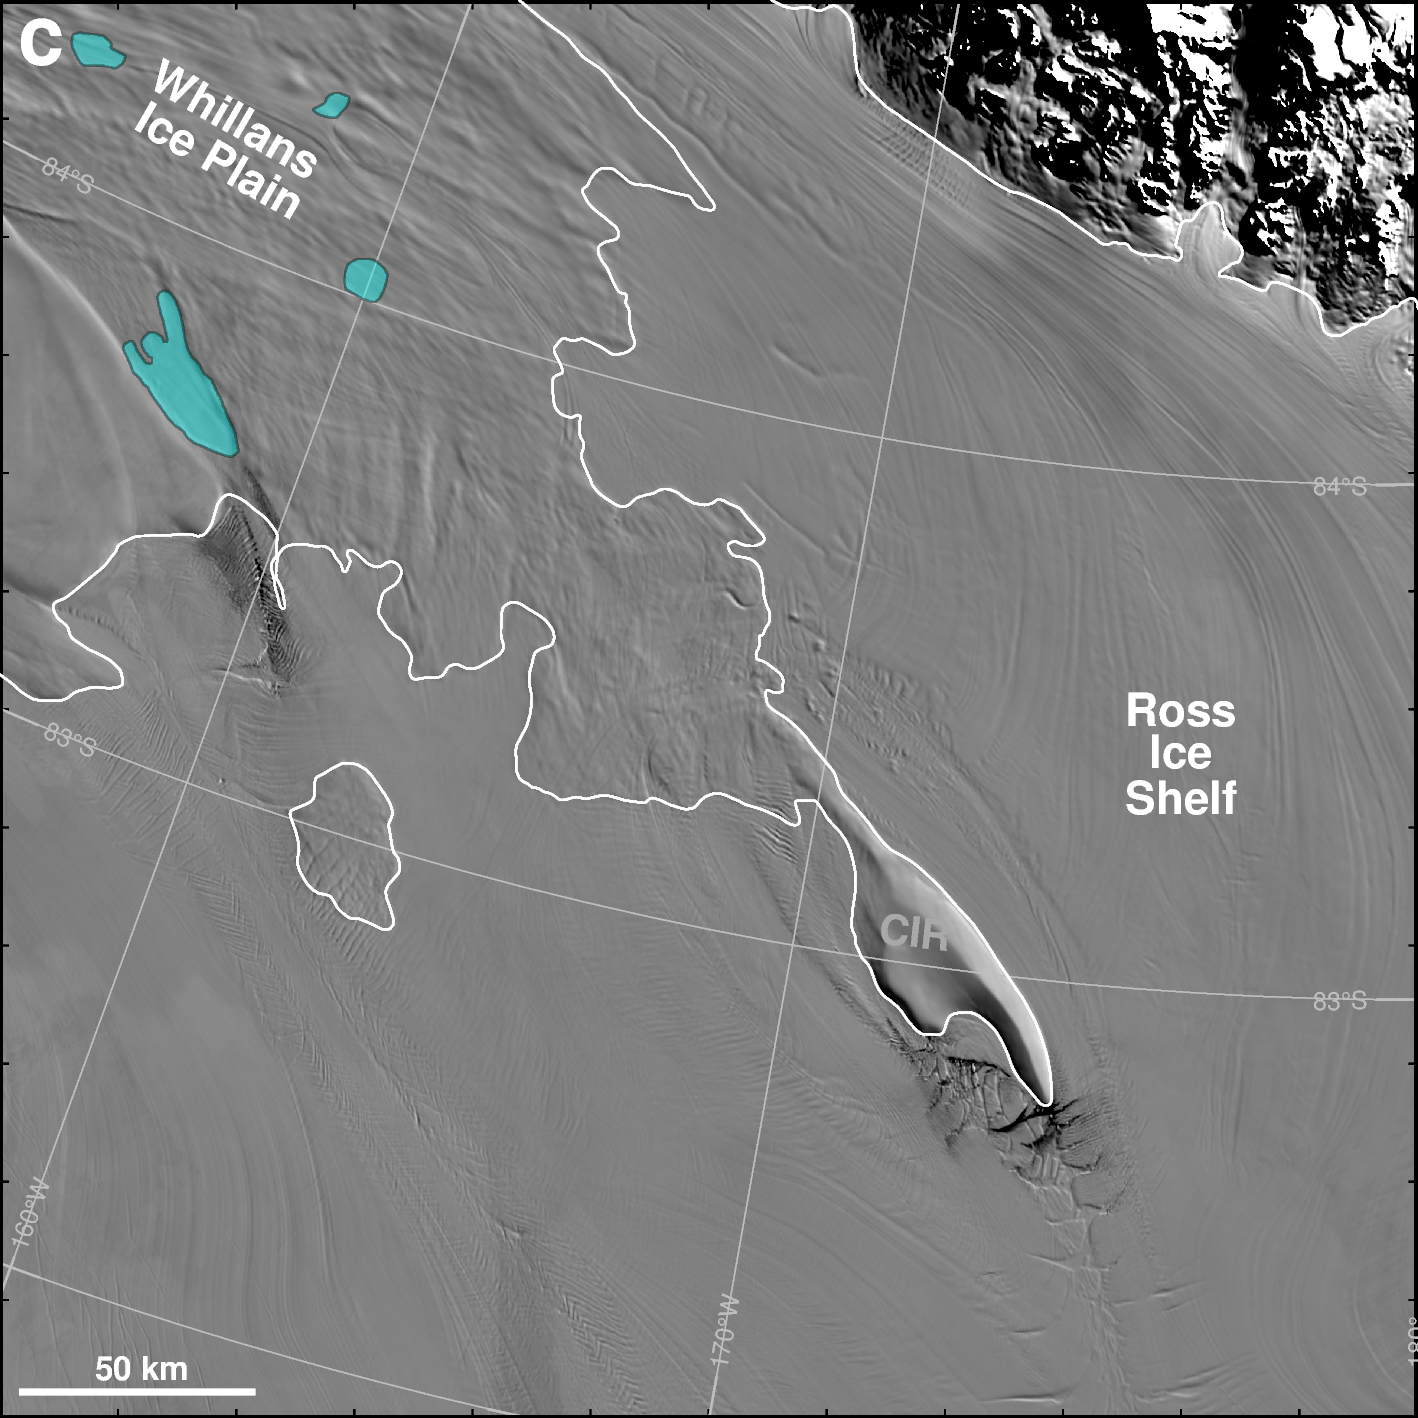

In [63]:
figwidth=120 # in mm

# Region for main part of the figure
wid_km = 300 # region width
hgt_km = 300 # region height
cir_xl=-300000 # polar stereographic bounds
cir_xh=0 
cir_yl=-850000 
cir_yh=-550000

cirratio = (cir_xh - cir_xl) / (figwidth/1000)
figheight=figwidth*(cir_yh-cir_yl)/(cir_xh-cir_xl)

cirreg = str(cir_xl) + '/' + str(cir_xh) + '/' + str(cir_yl) + '/' + str(cir_yh)
cirproj = "x1:" + str(cirratio)
cirproj_ll = "s0/-90/-71/1:" + str(cirratio)

# gray topographic background, overlay velocity in plasma colorscale
pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', continuous = True, output = 'moa.cpt')
with pygmt.config(COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [0,255], cmap = 'polar', output = 'dhdt.cpt')

# define the fig and plot the background
fig = pygmt.Figure()
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(region = cirreg, projection = cirproj, frame=["nwse", "xf25000", "yf25000"], 
                 grid = moa, cmap = 'moa.cpt')
    
# if (not quickplot):
#     vel_mag = (veldata['VX']**2 + veldata['VY']**2)**0.5
#     fig.grdimage(grid = dhdtdata.Band1, cmap = 'dhdt.cpt', transparency = 80)

# Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 1, FONT_ANNOT_PRIMARY = '6p,grey',
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '10p',
                  MAP_TICK_PEN_PRIMARY = 'thinner,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = cirproj_ll, region = cirreg,
                frame = ["SnWE", "xa10g10", "ya1g1"])

if not quickplot:
    fig.plot(region = cirreg, projection = cirproj,
             data = gdf, 
             pen = "0.5p,black", 
             color = 'cyan', 
             transparency = 60)
    fig.plot(data = gl, pen = '0.5p,white')    
    
## Plot scale bar in lower left
wid = 50000 # scale bar width, in m
xoff = 4050 # distance from left to put scale bar, in m
yoff = 5500 # distance from bottom to put scale bar, in m
xleft = xoff
xmid = xoff + wid/2
xright = xoff + wid
fig.plot(x = [cir_xl + xleft, cir_xl + xright], y = [cir_yl + yoff, cir_yl + yoff], pen = '1.5p,white')
fig.text(x = cir_xl + xmid, y = cir_yl + yoff, text = '{:3.0f}'.format(wid/1000) + ' km', 
         font = '8p,Helvetica-Bold,white', justify = 'BC', offset = '0/0.1c')

# plot letter in upper left (9 pt helvetica)
fig.text(x = cir_xl, y = cir_yh, text = 'c', font = '20p,Helvetica-Bold,white', justify = 'TL', offset = '0.15c/-0.15c')

# label RIS, CIR, NSS, Crary Peninsula, SLE, WIP
!echo -50000 -700000 MC Ross > tmptxt
!echo -50000 -709000 MC Ice >> tmptxt
!echo -50000 -718500 MC Shelf >> tmptxt
fig.text(textfiles = 'tmptxt', font = '11p,Helvetica-Bold,white', justify = True)
os.remove('tmptxt')
!echo -113500 -743000 TL CIR >> tmptxt
fig.text(textfiles = 'tmptxt', font = '10p,Helvetica-Bold,darkgrey', justify = True,angle = -6)
os.remove('tmptxt')
!echo -250000 -575000 MC Whillans > tmptxt
!echo -253400 -583800 MC Ice Plain >> tmptxt
fig.text(textfiles = 'tmptxt', font = '11p,Helvetica-Bold,white', justify = True, angle = -30)
os.remove('tmptxt')
fig.show()

In [ ]:
# save
out='Verboncoeur2024-fig1c.pdf'
fig.savefig(out)

# additional edits and annotations made with Affinity Designer